<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Transformers-Hub/blob/main/Sentiment-Analysis%20Zero-Shot-Classification/Zero_Shot_Classification_Airlines_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install -q transformers

# Import Libraries

In [ ]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Define Pipeline Classifier
using `zero-shot-classification`

In [ ]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


# Testing Classifier

In [ ]:
text = """
Artificial intelligence (AI) is a set of technologies that enable computers to perform a variety of advanced functions,
including the ability to see, understand and translate spoken and written language,
analyze data, make recommendations, and more.
"""

classifier(text, candidate_labels=['biology', 'math', 'geology', 'tech'])

{'sequence': '\nArtificial intelligence (AI) is a set of technologies that enable computers to perform a variety of advanced functions,\nincluding the ability to see, understand and translate spoken and written language,\nanalyze data, make recommendations, and more.\n',
 'labels': ['tech', 'geology', 'biology', 'math'],
 'scores': [0.9314194321632385,
  0.02806321531534195,
  0.02186969481408596,
  0.018647657707333565]}

# Import & Analyzing Dataset

In [ ]:
df_temp = pd.read_csv("/content/AirlineTweets.csv")
df_temp.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df_temp['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


# Modelling

In [ ]:
labels = list(set(df_temp['airline_sentiment']))
labels

['positive', 'neutral', 'negative']

In [ ]:
print(textwrap.fill(df_temp.iloc[100]['text']))

@VirginAmerica trying to add my boy Prince to my ressie. SF this
Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM


In [ ]:
# Check classifier with sample of dataset
classifier(df_temp.iloc[100]['text'], candidate_labels=labels)

{'sequence': '@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM',
 'labels': ['positive', 'negative', 'neutral'],
 'scores': [0.5693386197090149, 0.2219204157590866, 0.2087409943342209]}

In [ ]:
# Predictions
%%time
preds = classifier(df_temp['text'].tolist(), candidate_labels=labels)

CPU times: user 15min 11s, sys: 2.15 s, total: 15min 13s
Wall time: 15min 21s


In [ ]:
preds[:4]

[{'sequence': '@VirginAmerica What @dhepburn said.',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.5556523203849792, 0.2368909865617752, 0.20745672285556793]},
 {'sequence': "@VirginAmerica plus you've added commercials to the experience... tacky.",
  'labels': ['negative', 'positive', 'neutral'],
  'scores': [0.9926071166992188, 0.004191596992313862, 0.0032012758310884237]},
 {'sequence': "@VirginAmerica I didn't today... Must mean I need to take another trip!",
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9293215274810791, 0.04166318103671074, 0.02901529148221016]},
 {'sequence': '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9805808067321777, 0.010324854403734207, 0.00909433513879776]}]

In [ ]:
predicted_labels = [d['labels'] for d in preds]
df_temp['predicted_labels'] = predicted_labels # Add results in new col of df_temp

In [ ]:
# Convert prediction probs into and NxK matrix according to
# Original label order

N = len(df_temp)
K = len(labels)

label2idx = {v:k for k, v in enumerate(labels)}

probs = np.zeros((N, K))

for i in range(N):
    d = preds[i]
    for label, score in zip(d['labels'], d['scores']):
        k = label2idx[label]
        probs[i, k] = score

In [ ]:
int_labels = [label2idx[x] for x in df_temp['airline_sentiment']]
int_pred = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_pred)

<Axes: >

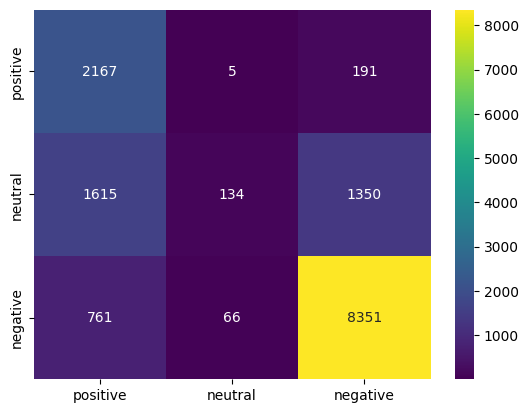

In [ ]:
sns.heatmap(cm, annot=True, cmap="viridis", fmt=".0f", xticklabels=labels, yticklabels=labels)

# **Class-Level Analysis**

1. **Positive Sentiment (True Positive)**  
   - Correct Predictions: **2167**  
   - Misclassified as Neutral: **5**  
   - Misclassified as Negative: **191**  
   - **Observation:** The model performs well in identifying positive sentiment, with minimal misclassifications.

2. **Neutral Sentiment (True Neutral)**  
   - Correct Predictions: **134**  
   - Misclassified as Positive: **1615**  
   - Misclassified as Negative: **1350**  
   - **Observation:** The model struggles significantly with neutral sentiment, often misclassifying it as positive or negative. This indicates difficulty in distinguishing neutral sentiment.

3. **Negative Sentiment (True Negative)**  
   - Correct Predictions: **8351**  
   - Misclassified as Positive: **761**  
   - Misclassified as Neutral: **66**  
   - **Observation:** The model excels in identifying negative sentiment, with very few misclassifications.

